In [1]:
import h5py
import cv2
from tqdm import tqdm
import torch
from matplotlib import pyplot as plt
import os, sys, numpy as np
import torch
from torch.utils.data import sampler, DataLoader
from skimage.transform import resize

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

from sononet.utils.util import json_file_to_pyobj
from sononet.models import get_model
from sononet.dataio.loader import get_dataset, get_dataset_path
from sononet.dataio.transformation import get_dataset_transformation
from sononet.utils.visualiser import Visualiser
from sononet.utils.error_logger import ErrorLogger
from sononet.models.networks_other import adjust_learning_rate

In [2]:
json_filename = 'configs/config_sononet_8_andi.json'
json_opts = json_file_to_pyobj(json_filename)
train_opts = json_opts.training

In [3]:
us_data = h5py.File('data/image_inp_224x288.hdf5')

In [4]:
cardiac_classes = [1, 2, 22, 29]

In [5]:
us_data['label_names'].value[cardiac_classes]

array([b'3VV', b'4CH', b'LVOT', b'RVOT'], dtype='|S16')

In [6]:
card_train_id = np.array([i in cardiac_classes for i in us_data['plane_labels_train'].value])
card_test_id = np.array([i in cardiac_classes for i in us_data['plane_labels_test'].value])

In [7]:
card_images_train = torch.tensor(us_data['images_train'][card_train_id,:,:,:])
card_labels_train = torch.tensor([{1: 0, 2:1, 22:2, 29:3}[lab] for lab in us_data['plane_labels_train'][card_train_id]])

card_images_test = torch.tensor(us_data['images_test'][card_test_id,:,:,:])
card_labels_test = torch.tensor([{1: 0, 2:1, 22:2, 29:3}[lab] for lab in us_data['plane_labels_test'][card_test_id]])

In [8]:
arch_type = train_opts.arch_type
ds_transform = get_dataset_transformation(arch_type, opts=json_opts.augmentation)



############# Augmentation Parameters #############
{'division_factor': (16, 16, 1),
 'inten_val': (1.0, 1.0),
 'name': 'us',
 'patch_size': [208, 272],
 'random_flip_prob': 0.5,
 'rotate_val': 15.0,
 'scale_size': (192, 192, 1),
 'scale_val': (0.7, 1.3),
 'shift_val': (0.1, 0.1)}
###################################################




In [9]:
class SimpleUSDataset(torch.utils.data.TensorDataset):
    def __init__(self, data, transform=None):
        super().__init__(*data)

        self.images = data[0]
        self.labels = data[1]

        self.label_names, lab_count = np.unique(self.labels, return_counts=True)
        self.n_class = len(self.label_names)
        self.weight = (1. / lab_count)[self.labels]
        
        # data augmentation
        self.transform = transform

    def __getitem__(self, index):

        indata  = self.images[index][0]
        target = self.labels[index]

        if self.transform:
            indata = self.transform(indata.numpy())
        return indata, int(target)

    def __len__(self):
        return len(self.images)

In [10]:
class AlteredUSDataset(torch.utils.data.TensorDataset):
    def __init__(self, data, transform=None):
        super().__init__(*data)

        self.images = data[0]
        self.labels = data[1]
        self.embedding = data[2]

        self.label_names, lab_count = np.unique(self.labels, return_counts=True)
        self.n_class = len(self.label_names)
        self.weight = (1. / lab_count)[self.labels]
        
        # data augmentation
        self.transform = transform

    def __getitem__(self, index):

        indata  = self.images[index][0]
        target = self.labels[index]
        emb = self.embedding[index]

        if self.transform:
            indata = self.transform(indata.numpy())
        return indata, int(target), emb

    def __len__(self):
        return len(self.images)

In [11]:
train_dataset = SimpleUSDataset(
    (card_images_train, card_labels_train),
    transform=ds_transform['train'])
train_dataset_for_acc = SimpleUSDataset(
    (card_images_train, card_labels_train),
    transform=ds_transform['valid'])
test_dataset = SimpleUSDataset(
    (card_images_test, card_labels_test),
        transform=ds_transform['valid'])

In [12]:
batch_size = train_opts.batchSize
train_sampler = sampler.WeightedRandomSampler(train_dataset.weight, batch_size)

In [13]:
train_loader = DataLoader(train_dataset,
    num_workers=0,
    batch_size=batch_size,
    shuffle=True)
#    sampler=train_sampler)

train_loader_for_acc = DataLoader(train_dataset,
    num_workers=0,
    batch_size=batch_size,
    shuffle=False)

test_loader  = DataLoader(test_dataset,
    num_workers=0,
    batch_size=batch_size,
    shuffle=False)

In [14]:
import sys

def print_accuracy(model, fold):
    model.net.eval()
    if fold == 'train':
        loader = train_loader_for_acc
    elif fold == 'test':
        loader = test_loader
    labels = []
    preds = []
    for (img, lab) in loader:
        labels.append(lab.cpu())
        model.set_input(img)
        model.forward(split='test')
        preds.append(model.logits.cpu().argmax(dim=1))
    labels = torch.cat(labels)
    preds = torch.cat(preds)
    acc = (labels==preds).sum().float() / len(labels)
    print('Accuracy {fold}: {acc}'.format(
        fold=fold, acc=acc
    ))

In [16]:
model = get_model(json_opts.model)


Initialising model sononet2
Network is initialized
sononet(
  (conv1): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv3): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(

In [57]:
model.set_labels([0,1,2,3])
model.set_scheduler(train_opts)
model.load_network(model.net, 'S', 50)
model.update_state(0)

opt.lr_policy = [step_warmstart]
Scheduler is added for optimiser SGD (
Parameter Group 0
    dampening: 0
    initial_lr: 0.1
    lr: 0.010000000000000002
    momentum: 0.9
    nesterov: True
    weight_decay: 1e-06
)
Loading the model S - epoch 50


In [17]:
for epoch in tqdm(range(1, 51)):
    for (images, labels) in train_loader:
        # Make a training update
        model.net.train()
        model.set_input(images, labels)
        model.optimize_parameters()

    if epoch % 5 == 0:
        model.save(epoch)
        print_accuracy(model, 'train')
        print_accuracy(model, 'test')

    if epoch == 25:
        model.update_learning_rate()

        #model.update_learning_rate(metric=valid_err, epoch=epoch)

8%|▊         | 4/50 [00:33<06:26,  8.41s/it]Saving the model S at the end of epoch 5
Accuracy train: 0.469453364610672
 18%|█▊        | 9/50 [01:27<06:30,  9.53s/it]Saving the model S at the end of epoch 10
Accuracy train: 0.5857449173927307
 28%|██▊       | 14/50 [02:23<06:01, 10.04s/it]Saving the model S at the end of epoch 15
Accuracy train: 0.6034297943115234
 38%|███▊      | 19/50 [03:21<05:20, 10.33s/it]Saving the model S at the end of epoch 20
Accuracy train: 0.6704180240631104
 48%|████▊     | 24/50 [04:20<04:34, 10.55s/it]Saving the model S at the end of epoch 25
Accuracy train: 0.6864951848983765
 50%|█████     | 25/50 [04:41<05:44, 13.79s/it]Accuracy test: 0.7625330090522766
current learning rate = 0.0100000
 58%|█████▊    | 29/50 [05:21<03:48, 10.89s/it]Saving the model S at the end of epoch 30
Accuracy train: 0.6012861728668213
 68%|██████▊   | 34/50 [06:23<02:55, 10.97s/it]Saving the model S at the end of epoch 35
Accuracy train: 0.6307609677314758
 78%|███████▊  | 39/50 

In [59]:
print_accuracy(model, 'train')

Accuracy train: 0.7481243014335632


In [18]:
def get_logits(model, fold, softmax=True):
    model.net.eval()
    with torch.no_grad():
        if fold == 'train':
            loader = train_loader_for_acc
        elif fold == 'test':
            loader = test_loader
        labels = []
        logits = []
        for (img, lab) in loader:
            labels.append(lab.cpu())
            model.set_input(img)
            model.forward(split='test')
            if softmax:
                logits.append(model.logits.cpu())
            else:
                logits.append(model.prediction.cpu())
        labels = torch.cat(labels)
        logits = torch.cat(logits)
        return logits, labels

In [60]:
foo, bar = get_logits(model, 'train', softmax=False)

In [45]:
from ptsne.ptsne import ParametricTSNE

In [61]:
ptsne = ParametricTSNE(4, 2, 50, use_cuda=True, hidden_layer_dims=[200,50], alpha='learn')

In [62]:
ptsne.fit(foo, pretrain=True, verbose=True)

Calculating PCA
2020-03-11 20:44:59.957515: Beginning pretraining for 5 epochs
2020-03-11 20:45:00.010516: Loss after epoch 0: 5.886622190475464
2020-03-11 20:45:00.057516: Loss after epoch 1: 1.954560786485672
2020-03-11 20:45:00.099515: Loss after epoch 2: 1.2135259360074997
2020-03-11 20:45:00.141512: Loss after epoch 3: 0.4993135780096054
2020-03-11 20:45:00.179517: Loss after epoch 4: 0.20578749291598797
2020-03-11 20:45:00.179517: Finished pretraining
Indexing
2020-03-11 20:45:05.295343: Beginning training for 10 epochs
2020-03-11 20:45:05.405341: Loss after epoch 1: 6.453686673143887
2020-03-11 20:45:05.525855: Loss after epoch 2: 3.9198941082809275
2020-03-11 20:45:05.648857: Loss after epoch 3: 3.5430205241127455
2020-03-11 20:45:05.766861: Loss after epoch 4: 3.4576255444428137
2020-03-11 20:45:05.893855: Loss after epoch 5: 3.489562904089632
2020-03-11 20:45:06.018855: Loss after epoch 6: 3.4108509063313814
2020-03-11 20:45:06.142856: Loss after epoch 7: 3.3878958932175953
2

In [63]:
projected = ptsne(foo.cuda()).cpu().detach()

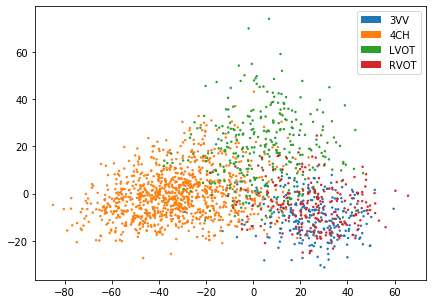

In [64]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in bar]
ax.scatter(projected[:,0], projected[:,1], c=colors, s=2)
ax.set_aspect(1)
recs = []
for i in range(0,4):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs, [i.decode('UTF-8') for i in us_data['label_names'].value[cardiac_classes]],loc=1)

In [68]:
shift = (card_labels_train == 3).float().unsqueeze(1) * torch.tensor([0.,20.]) #+ (card_labels_train == 3).float().unsqueeze(1) * torch.tensor([10.,10.])
shifted_train = projected + shift

In [67]:
shifted_train = torch.cat((
    (1./4. * projected[(card_labels_train == 0)] + 3./4. * projected[(card_labels_train == 0)].mean(axis=0)),
    (1./2. * projected[(card_labels_train == 1)] + 1./2. * projected[(card_labels_train == 1)].mean(axis=0)),
    (1./2. * projected[(card_labels_train == 2)] + 1./2. * projected[(card_labels_train == 2)].mean(axis=0)),
    (1./3. * projected[(card_labels_train == 3)] + 2./3. * projected[(card_labels_train == 3)].mean(axis=0)) + torch.tensor([-5.,+5.]) 
))

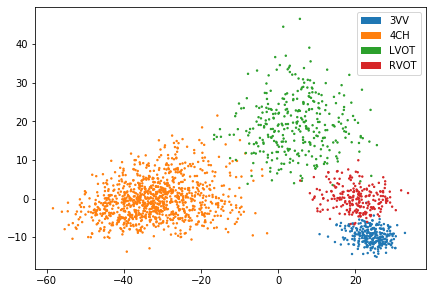

In [68]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in bar]
ax.scatter(shifted_train[:,0], shifted_train[:,1], c=colors, s=2)
ax.set_aspect(1)
recs = []
for i in range(0,4):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs, [i.decode('UTF-8') for i in us_data['label_names'].value[cardiac_classes]],loc=1)

In [69]:
shifted_dataset = AlteredUSDataset((card_images_train, card_labels_train, shifted_train), transform=ds_transform['train'])
shifted_loader = DataLoader(shifted_dataset, batch_size=batch_size, shuffle=True)
shifted_dataset_no_tf = AlteredUSDataset((card_images_train, card_labels_train, shifted_train), transform=ds_transform['valid'])
shifted_loader_noshuffle = DataLoader(shifted_dataset_no_tf, batch_size=batch_size, shuffle=False)

In [70]:
model.optimizer.param_groups[0]['lr'] = 0.01
for epoch in tqdm(range(1, 21)):
    for (images, labels, emb) in shifted_loader:
        # Make a training update
        model.net.train()
        model.set_input(images, labels)
        model.optimize_parameters_altered(ptsne, emb.cuda(), 0.3)

    if epoch % 2 == 0:
        #model.save(epoch)
        print_accuracy(model, 'train')
        print_accuracy(model, 'test')
    
    if epoch == 15:
        model.optimizer.param_groups[0]['lr'] = 0.001

    # if epoch == 25:
    #     model.update_learning_rate()

        #model.update_learning_rate(metric=valid_err, epoch=epoch)

100%|██████████| 20/20 [04:44<00:00, 14.24s/it]Accuracy test: 0.8021107912063599



In [121]:
only_classification_train = get_logits(model, 'train', softmax=False)
only_classification_test = get_logits(model, 'test', softmax=False)

In [54]:
half_half_train = get_logits(model, 'train', softmax=False)
half_half_test = get_logits(model, 'test', softmax=False)

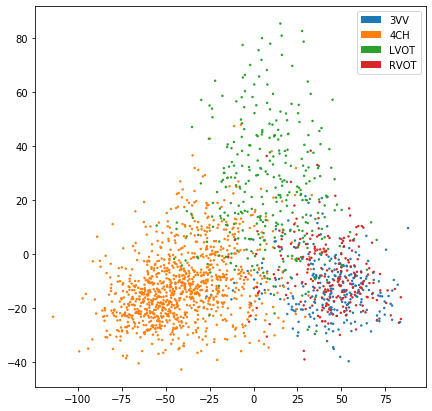

In [122]:
projected_altered = ptsne(only_classification_train[0].cuda()).cpu().detach()
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in only_classification_train[1]]
ax.scatter(projected_altered[:,0], projected_altered[:,1], c=colors, s=2)
#ax.set_aspect(1)
recs = []
for i in range(0,4):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs, [i.decode('UTF-8') for i in us_data['label_names'].value[cardiac_classes]],loc=1)

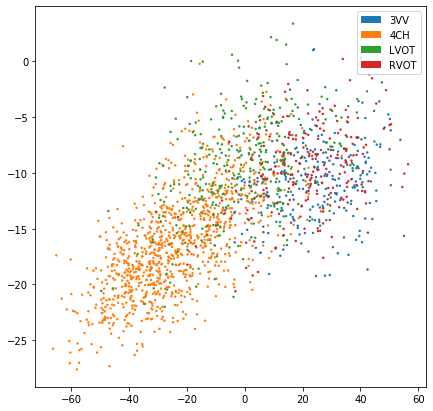

In [55]:
projected_altered = ptsne(half_half_train[0].cuda()).cpu().detach()
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in half_half_train[1]]
ax.scatter(projected_altered[:,0], projected_altered[:,1], c=colors, s=2)
#ax.set_aspect(1)
recs = []
for i in range(0,4):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs, [i.decode('UTF-8') for i in us_data['label_names'].value[cardiac_classes]],loc=1)

In [123]:
np.unique(only_classification_train[0].softmax(dim=1).argmax(dim=1).numpy(),return_counts=True)

(array([0, 1, 2, 3], dtype=int64),
 array([ 294, 1101,  355,  116], dtype=int64))

In [124]:
np.unique(only_classification_test[0].softmax(dim=1).argmax(dim=1).numpy(),return_counts=True)

(array([0, 1, 2, 3], dtype=int64), array([ 58, 255,  47,  19], dtype=int64))

In [116]:
np.unique(half_half_train[0].softmax(dim=1).argmax(dim=1).numpy(),return_counts=True)

(array([0, 1, 2, 3], dtype=int64),
 array([ 108, 1161,  446,  151], dtype=int64))

In [117]:
np.unique(half_half_test[0].softmax(dim=1).argmax(dim=1).numpy(),return_counts=True)

(array([0, 1, 2, 3], dtype=int64), array([ 29, 262,  68,  20], dtype=int64))

In [136]:
def confmat(data):
    cf = torch.zeros(4,4, dtype=torch.int)
    for logits, label, in zip(*data):
        cf[label, logits.softmax(dim=0).argmax()] += 1
    return cf

In [147]:
def accuracy(data):
    cf = confmat(data)
    diag = cf.diagonal().sum()
    total = cf.sum()
    return diag.float() / total

In [148]:
accuracy(half_half_train)

tensor(0.7567)

In [149]:
accuracy(only_classification_train)

tensor(0.7889)

In [ ]:
torch.manual_seed(12)
torch.cuda.manual_seed(12)
torch.backends.cudnn.deterministic=True

for train_loader